CS524: Introduction to Optimization Lecture 28
======================================

## Michael Ferris<br> Computer Sciences Department <br> University of Wisconsin-Madison

## November 6, 2024
--------------

# Hovercraft example

We are in command of a hovercraft. We are given a set of $k$ waypoint locations and times. The objective is to hit the waypoints at the prescribed times while minimizing fuel use.  Example of discrete time dynamics.

* Discretize time: $t = 0,1,2,...,T$.
* Important variables: position $x_t$, velocity $v_t$, thrust $u_t$. 
* Simplified model of the dynamics:
  * $x_{t+1} =x_t + v_t$, for $t = 0, 1, . . . , T − 1$
  * $v_{t+1} =v_t +u_t$, for $t = 0, 1, . . . , T − 1$
* We must choose $u_0,u_1,...,u_{T-1}$.
* Initial position and velocity: $x_0 = 0$ and $v_0 = 0$. 
* Waypoint constraints: $x_{t_i} = w_i$ for $i = 1,...,k$. 
* Minimize fuel use: $$\left\Vert u_0 \right\Vert^2 + \left\Vert u_1\right\Vert^2 +\cdots+\left\Vert u_{T-1}\right\Vert^2$$

First model: hit all the waypoints exactly: compute solution
\begin{align*}
\min_{x_t,v_t,u_t} & \sum_{t=0}^{T-1} \left\Vert u_t \right\Vert^2 \\ 
\text{subject to } & x_{t+1} = x_t + v_t & \text{for $t=0,1,\ldots,T-1$}\\
& v_{t+1} = v_t + u_t & \text{for $t=0,1,\ldots,T-1$}\\
& x_0 = v_0 = 0 \\
& x_{t_i} = w_i & \text{for $i=1,\ldots,k$}
\end{align*}

Generate data and share it with the gams environment.

In [1]:
import gamspy as gp
import gamspy.math as gpm
from gamspy import Sum, Card

import sys
import numpy as np

m = gp.Container()

T = [0, 20, 50, 60]
t = m.addSet('t', records=range(0,max(T)+1))
c = m.addSet('c', description='coordinates',records=['x', 'y'])
k = m.addSet('k', description='number of waypoints',records=range(1,5))
w = m.addParameter('w',[c,k],description='vector of waypoint locations',records=np.array([[1,4,6,1],[1,3,0,1]]))
wtPts = w.pivot()
display(wtPts)
tp = m.addSet('tp',[k,t],description='timepoints',records=[(str(x[0]),str(x[1])) for x in zip(range(1,5),T)])
x = m.addVariable('x','free',[c,t],description='resulting position')

,1,2,3,4
x,1.0,4.0,6.0,1.0
y,1.0,3.0,0.0,1.0


In [2]:
lamTO = m.addParameter('lamTO',description='tradeoff parameter',records=0)
v = m.addVariable('v','free',domain=[c,t],description='resulting velocity')
u = m.addVariable('u','free',domain=[c,t],description='thruster input')

# simplified dynamics
dyn1 = m.addEquation('dyn1', domain=[c,t])
dyn1[c,t].where[~t.last]= (
    x[c,t.lead(1)] == x[c,t] + v[c,t] )

dyn2 = m.addEquation('dyn2', domain=[c,t])
dyn2[c,t].where[~t.last]= (
    v[c,t.lead(1)] == v[c,t] + u[c,t] )
  
hover = m.addModel('hover',
    equations=m.getEquations(),
    problem=gp.Problem.QCP,
    sense=gp.Sense.MIN,
    objective=Sum(t.where[~t.last], Sum(c, gpm.sqr(u[c,t])))
    + lamTO*Sum(k.where[~k.first], Sum(tp[k,t], Sum(c, gpm.sqr(x[c,t] - w[c,k]))))
)

# satisfy the dynamics (with zero initial velocity)
v.fx[c,'0'] = 0

# hit all the waypoints
for kval in k.toList():
    x.fx[c,t].where[tp[kval,t]] = w[c,kval]

hover.solve(options=gp.Options(qcp="conopt"),output=None)

,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Normal,OptimalLocal,0.0407705464472504,241,365,QCP,CONOPT,0.006


objective=0.040771


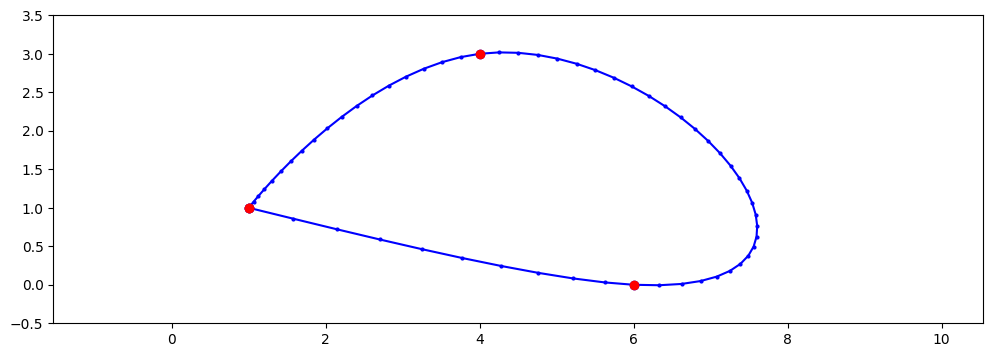

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_traj(x): 
    xval = x.pivot().T
    fig, ax = plt.subplots(figsize=(12,4))
    ax.plot( xval['x'], xval['y'], "b.-", markersize=4 )
    ax.plot( xval['x'].iloc[T], xval['y'].iloc[T], "b.", markersize=12 )
    ax.plot( wtPts.loc['x'], wtPts.loc['y'], "r.", markersize=12 )
    ax.axis("equal")
    ax.axis((1.,8.,-.5,3.5));

print(f'objective={hover.objective_value:f}')
plot_traj(x)

Second model: allow waypoint misses

\begin{align*}
\min_{x_t,v_t,u_t} & \sum_{t=0}^{T-1} \left\Vert u_t \right\Vert^2 + \lambda \sum_{i=1}^k \left\Vert x_{t_i} - w_i \right\Vert^2 \\ 
\text{subject to } & x_{t+1} = x_t + v_t & \text{for $t=0,1,\ldots,T-1$}\\
& v_{t+1} = v_t + u_t & \text{for $t=0,1,\ldots,T-1$}\\
& x_0 = v_0 = 0 
\end{align*}

$\lambda$ controls the tradeoff between making $u$ small and hitting all the waypoints.

In [4]:
# now release the bounds and penalize errors
for kval in ['2','3','4']:
    x.lo[c,t].where[tp[kval,t]] = gp.SpecialValues.NEGINF 
    x.up[c,t].where[tp[kval,t]] = gp.SpecialValues.POSINF
lamTO.setRecords(0.01)

J1 = m.addParameter('J1')
J2 = m.addParameter('J2')

hover.solve(options=gp.Options(qcp="conopt"),output=None)

J1[:]= Sum(t, Sum(c, gpm.sqr(u.l[c,t])))
J2[:]= Sum(k.where[~k.first], Sum(tp[k,t], Sum(c, gpm.sqr(x.l[c,t] - w[c,k]))))

Fuel cost: J1=0.027582 Waypoint mismatch: J2=0.574088


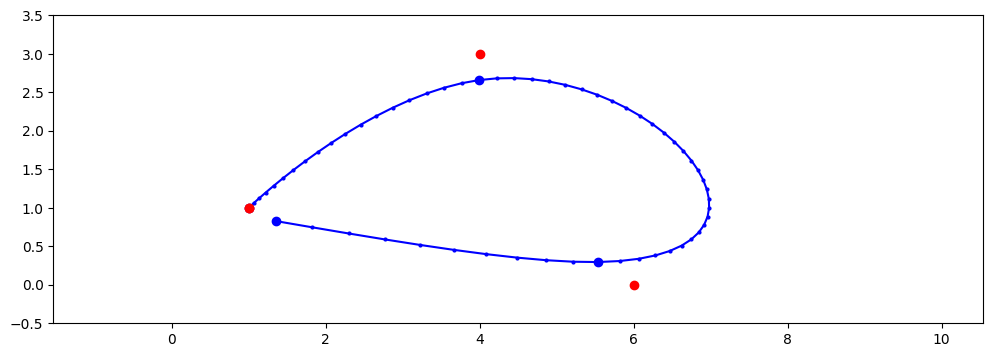

In [5]:
print(f'Fuel cost: J1={J1.toValue():f} Waypoint mismatch: J2={J2.toValue():f}')
plot_traj(x)

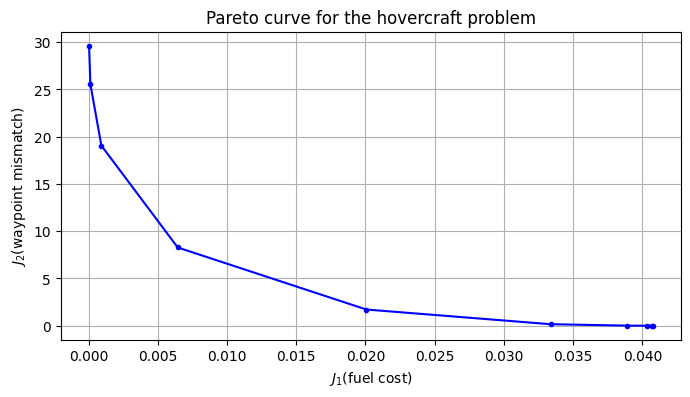

In [ ]:
Npts = 10
iter = np.logspace(-5,1,Npts)
sol1 = []
sol2 = []

for lamval in iter:
    lamTO.setRecords(lamval)
    hover.solve(options=gp.Options(qcp="conopt"),output=None)
    if hover.status in [
        gp.ModelStatus.OptimalGlobal,
        gp.ModelStatus.OptimalLocal,
    ]:
        J1[:]= Sum(t, Sum(c, gpm.sqr(u.l[c,t])))
        J2[:]= Sum(k.where[~k.first], Sum(tp[k,t], Sum(c, gpm.sqr(x.l[c,t] - w[c,k]))))

        sol1.append(J1.toValue())
        sol2.append(J2.toValue())
    else:
        print(hover.status)
        sol1.append('NaN')
        sol2.append('NaN')
        break

fig, ax = plt.subplots(figsize=(8,4))
ax.plot( sol1, sol2, "b.-" )
ax.set_xlabel("$J_1$(fuel cost)")
ax.set_ylabel("$J_2$(waypoint mismatch)")
ax.set_title("Pareto curve for the hovercraft problem")
ax.grid();